# Group Project
### Members:
- Minh Au
- Andrew Carriere
- Veronika Bumbulovic
- Kevin Yoon Jeong

## Introduction
Heart disease is the second leading cause of death in Canada after cancer1. The cause of heart disease is multifactorial and has been linked to smoking, dyslipidemia, hypertension, diabetes, obesity, and their lifestyle2. In this project we will explore how some factors impact the likelihood of developing heart disease. The dataset used was sourced from the UC Irvine Machine Learning Repository and the data was collected by Andras Janosi, M.D. at the Hungarian Institute of Cardiology.


## Preliminary exploratory data analysis
The following two cells will load necessary libraries and read in the data which is necessary as the first step for the analysis.

In [101]:
library(tidyverse)
library(repr)
library(tidymodels)

In [299]:
# Reading the data
hungarian_heart_data <- read_csv("data/hungarian-heart.csv", col_names = FALSE)
longbeach_heart_data <- read_csv("data/long-beach-va-heart.csv", col_names = FALSE)
switzerland_heart_data <- read_csv("data/switzerland-heart.csv", col_names = FALSE)
# Combine different data sets into one
heart_data <- rbind(hungarian_heart_data, longbeach_heart_data) |>
    rbind(switzerland_heart_data)
head(heart_data, 10)

Rows: 2940 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1230 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1
<chr>
1254 0 40 1 1 0 0
-9 2 140 0 289 -9 -9 -9
0 -9 -9 0 12 16 84 0
0 0 0 0 150 18 -9 7
172 86 200 110 140 86 0 0
0 -9 26 20 -9 -9 -9 -9
-9 -9 -9 -9 -9 -9 -9 12
20 84 0 -9 -9 -9 -9 -9
-9 -9 -9 -9 -9 1 1 1


As seen in the small subset above, the data is not in tidy format and thus, is not ready for analysis. From the documentations, we know that there are 76 attributes, but currently, they are all grouped in one column. Furthermore, the 76 attributes are spread across 10 different lines with different number of attributes on each line (some with 7 while the others only have 8). As such, the data wrangling strategy is as follows:
1. Combine the 76 attributes into one row. They need to be separated by a specific delimiter such as ",".
2. Each rows are separated out into multiple columns.
3. Load the names of the attributes 
3. Select the following factors as decribed in the method section and convert them into correct type
    - age - age in years
    - sex - 0 for female, 1 for male
    - chol - serum cholestoral in mg/dl 
    - cigs - cigarettes per day
    - years - number of years as a smoker
    - thalach - maximum heart rate achieved 
    - thalrest - resting heart rate
    - trestbpd - resting blood pressure
    - num - diagnosis of heart disease (0 for absence, 1 - 4 for present)

In [300]:
# Separate the data with commas
separated_with_commas <- heart_data |>
    separate(col = X1, into = c("X1", "X2", "X3", "X4", "X6", "X7", "X8", "X9"), sep = " ") |>
    rowwise() |>
    mutate(combined_col = paste0(str_replace_na(c_across(X1:X9), replacement = ""), collapse = ",")) |>
    ungroup() |>
    select(combined_col)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1235 rows [1, 10, 11, 20, 21, 30, 31, 40, 41, 50, 51, 60, 61, 70, 71, 80, 81, 90, 91, 100, ...].”


In [328]:
# Combine rows and split columns before assigning names
clean_data <- separated_with_commas |>
    mutate(num = ceiling(row_number() / 10)) |>
    group_by(num) |>
    summarise(combined_col = gsub(',,', ',', gsub('NA', '', paste0(combined_col, collapse = ",")))) |>
    ungroup() |>
    separate(col = combined_col, into = c('id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name'), sep = ",")
head(clean_data, 1)
# Processing the data
processed_heart_data <- clean_data |>
    select(age, sex, chol, cigs, years, thalach, thalrest, trestbpd, num) |>
    mutate(age = as.numeric(age), sex = as_factor(sex), chol = as.numeric(chol), cigs = as.numeric(cigs), 
          years = as.numeric(years), thalach = as.numeric(thalach), thalrest = as.numeric(thalrest), 
           trestbpd = as.numeric(trestbpd), num = as.numeric(num))
head(processed_heart_data, 5)

Warning message:
“Expected 76 pieces. Additional pieces discarded in 616 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 76 pieces. Missing pieces filled with `NA` in 1 rows [290].”


id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,⋯,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1254,0,40,1,1,0,0,-9,2,140,⋯,-9,-9,1,1,1,1,1,-9.,-9.,name


age,sex,chol,cigs,years,thalach,thalrest,trestbpd,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,289,-9,-9,172,86,86,0
49,0,180,-9,-9,156,100,90,1
37,1,283,-9,-9,98,58,80,0
48,0,214,-9,-9,108,54,86,3
54,1,-9,-9,-9,122,74,90,0


According to the documentation of the dataset, fields with -9 value is simply missing data. And, as seen in the first five rows of the data, `cigs` and `years` contain only -9 as values. In fact, this persists for most of the dataset. If we remove all the rows with that have -9 for those two factors, the dataset would be reduced significantly. As such, we cannot use cigarettes as predictor for the model since we don't have enough information on them. <br>
Also, note that the diagnosis for a heart disease is either present or absent. So it's a binary category and it would be better to be represented as 0 and 1. Therefore, let 0 and 1 be the absence and the presence of the heart disease respesctively. Also, let the column name be **diagnosis** for more clarity. <br>
We should also replace the fields with -9 values with NA to be consistent with R's convention.

In [329]:
# Final steps of wrangling the data
final_heart_data <- processed_heart_data |>
    mutate(diagnosis = 1 * (num >= 1)) |>
    mutate(diagnosis = as.factor(diagnosis)) |>
    select(-cigs, -years, -num)
final_heart_data[final_heart_data == -9] <- NA
head(final_heart_data, 5)

age,sex,chol,thalach,thalrest,trestbpd,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,1,289,172,86,86,0
49,0,180,156,100,90,1
37,1,283,98,58,80,0
48,0,214,108,54,86,1
54,1,NA,122,74,90,0


As a result, the table above shows a subset of the wrangled data. Now, we can split the data into training and testing sets to begin the analysis. Since there are 617 rows of data, 80% of the dataset will give us approximately 500 observations which is suitable to train the model. Therefore, the proportion between training data and testing data will be 80%.

In [317]:
# Splitting the data into training and testing
set.seed(1337) # Set seed for reproducility
heart_split <- initial_split(final_heart_data, prop = 0.8, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing (heart_split)

Now, let's examine training set for more information about the data. One useful data is the number of observations with heart disease and that without.

In [330]:
# Summarize the training data
heart_train |>
    group_by(diagnosis) |>
    summarize(count = n())

diagnosis,count
<fct>,<int>
0,197
1,296


As seen with the summary table, the number of people with heart disease differs those without by approximately 100 people. This is a significant amount, considering the size of the training set. Thus, it will be taken into account when the actual classification is done. <br>
Next, it will be useful to find the means of numerical factors after grouping the observations by the presence of heart disease as well as sex. It will highlight the difference between the two sex in the context of heart diseases.

In [331]:
# Summarize the training data
heart_train |>
    group_by(diagnosis, sex) |>
    summarise(count = n(), mean_age = mean(age, na.rm = TRUE), mean_chol = mean(chol, na.rm = TRUE),
             mean_thalach = mean(thalach, na.rm = TRUE), mean_thalrest = mean(thalrest, na.rm = TRUE),
             mean_trestbpd = mean(trestbpd, na.rm = TRUE))

`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,count,mean_age,mean_chol,mean_thalach,mean_thalrest,mean_trestbpd
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,142,49.33803,207.3910,141.0079,79.49606,83.48819
0,0,55,48.43636,236.9000,137.6296,79.35849,80.18519
1,1,276,55.85507,145.6517,123.4089,72.01220,81.90123
1,0,20,54.00000,170.4500,134.3500,80.05000,84.35000


Looking at the table, it could be seen that there are more men who have heart diseases than women. Moreover, it generally requires women to have higher health statistics to have heart conditions (except for age). For both sex, people with heart diseases are generally older than those without, according to the mean.

## Visualization

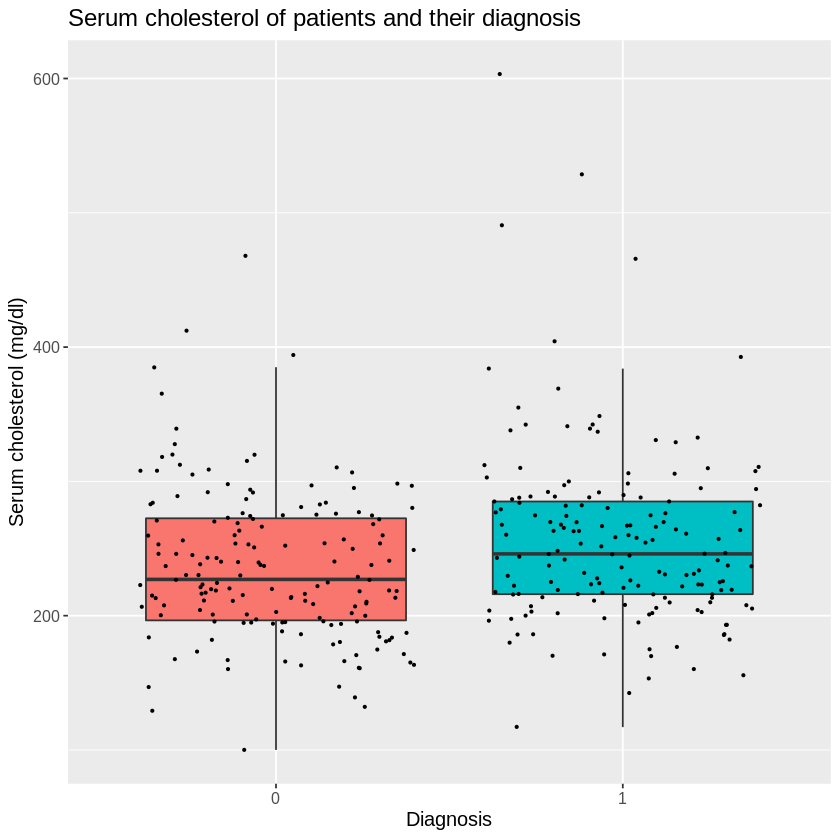

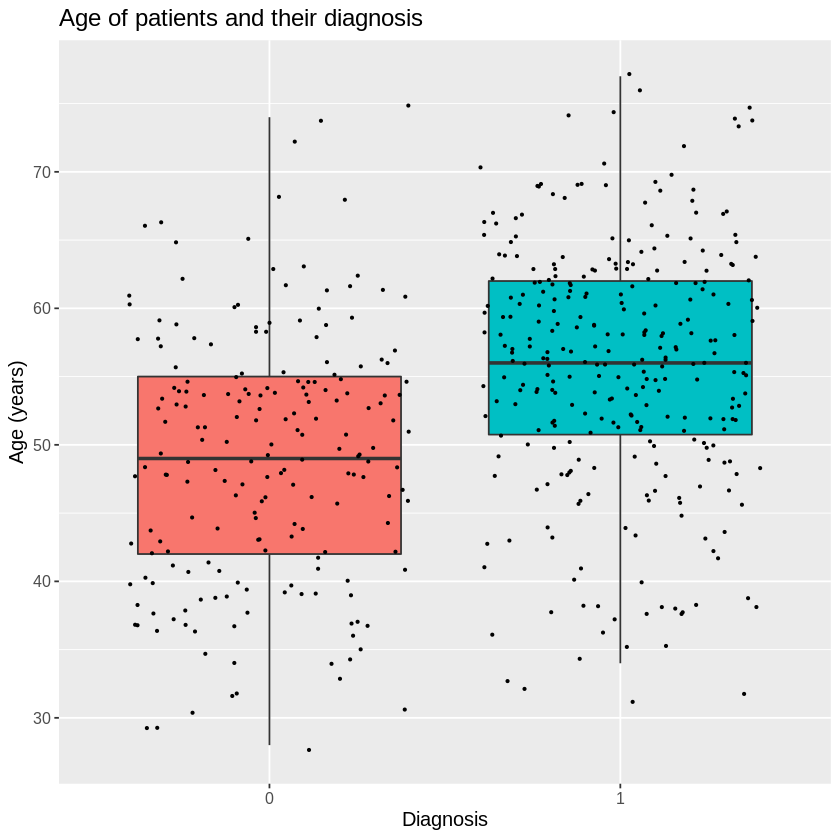

Warning message:
“Removed 47 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 47 rows containing missing values (geom_point).”


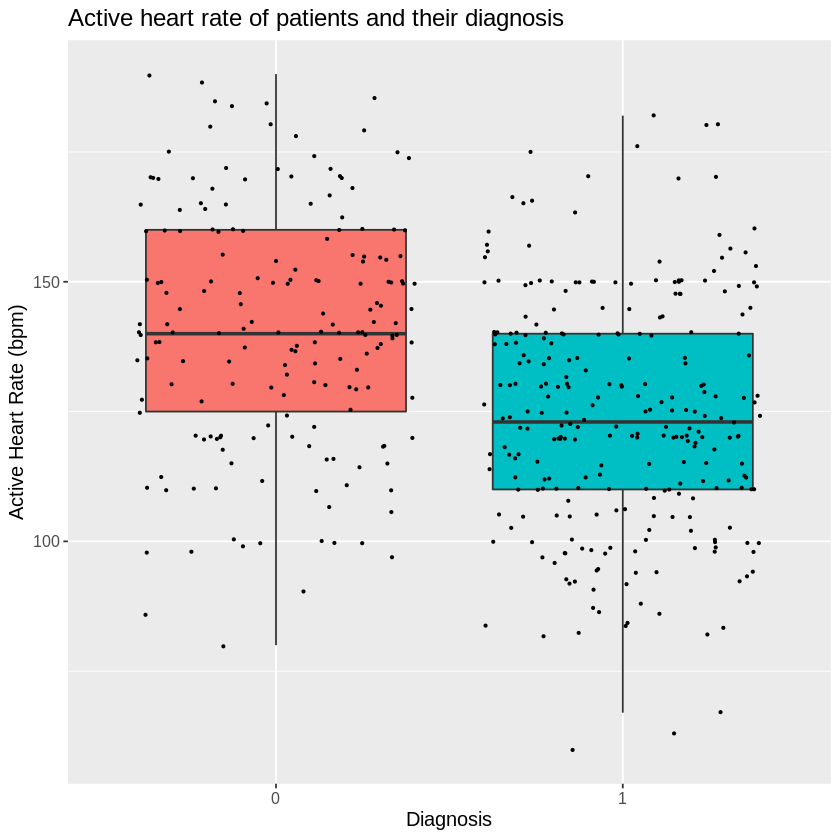

Warning message:
“Removed 49 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


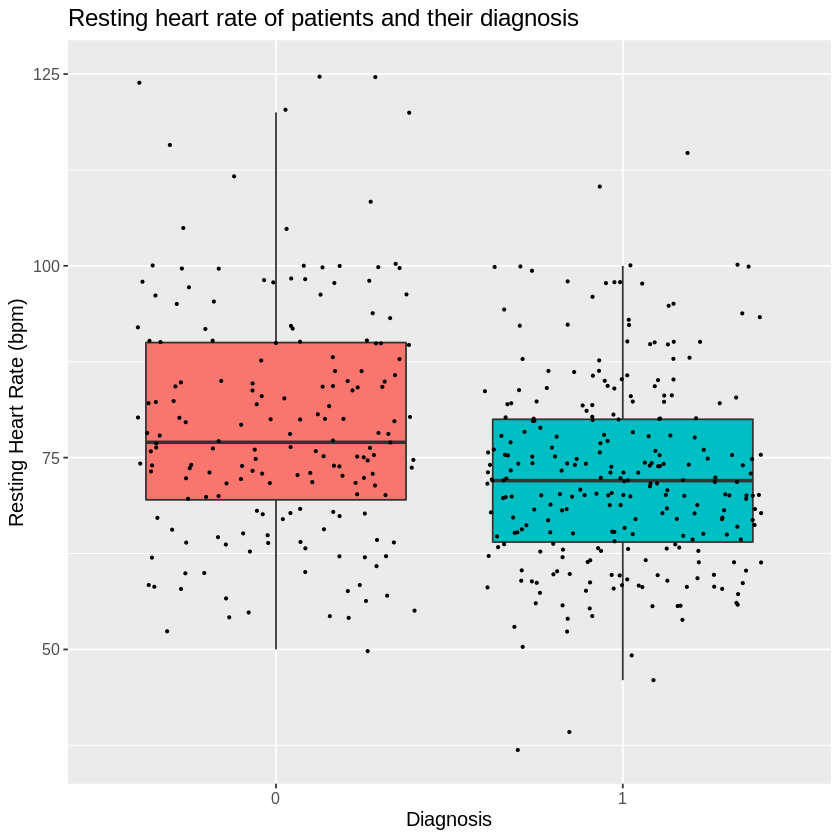

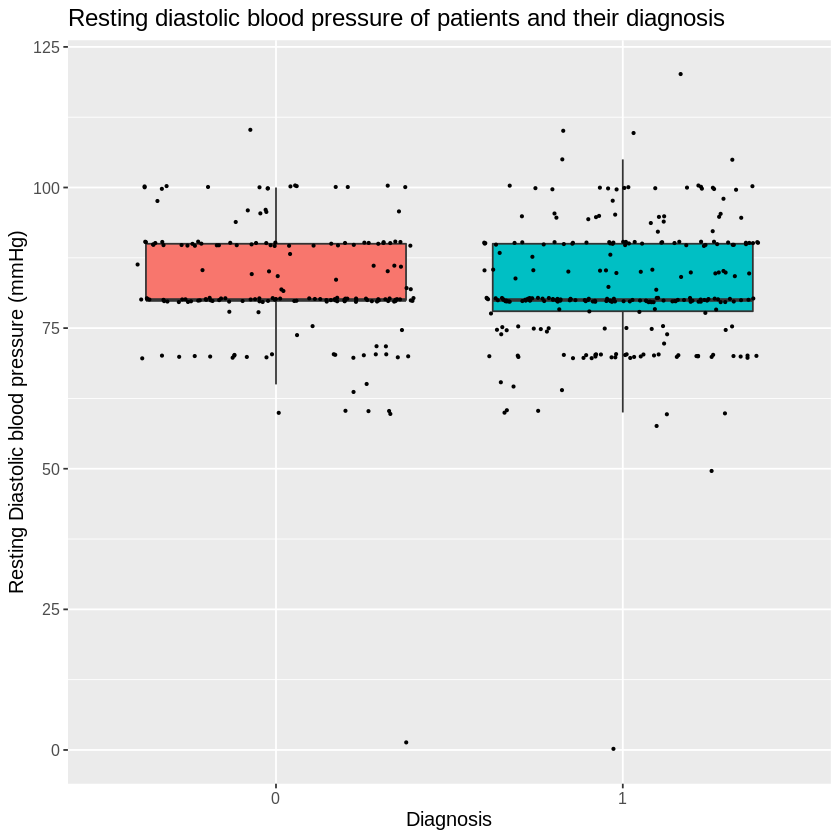

In [82]:
chol_plot <- heart_train |>
    filter(chol != 0) |>
    ggplot(aes(x = diagnosis, y = chol, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Serum cholesterol of patients and their diagnosis") +
        ylab("Serum cholesterol (mg/dl)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 
chol_plot

age_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = age, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Age of patients and their diagnosis") +
        ylab("Age (years)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12))
age_plot

thalach_plot <- heart_train |>
    filter(thalach > 0) |>
    ggplot(aes(x = diagnosis, y = thalach, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Active heart rate of patients and their diagnosis") +
        ylab("Active Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 
thalach_plot

thalrest_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = thalrest, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting heart rate of patients and their diagnosis") +
        ylab("Resting Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 
thalrest_plot

trestbpd_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = trestbpd, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting diastolic blood pressure of patients and their diagnosis") +
        ylab("Resting Diastolic blood pressure (mmHg)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 
trestbpd_plot

## Methods
We aim to create a highly accurate classification model. We will build a classification model for each factor that is easily measurable and significantly affects heart disease. These factors are age, sex, cholesterol, smoking, max heart rate, resting heart rate, and resting blood pressure. Then we choose three factors with the most accurate models to create our final model. To visualize each factor's accuracy, we will use a box plot. The final model percentage of false positives and false negatives will also be visualized 

## Expected Outcome and Significance
Heart disease is the leading cause of death around the globe, with 19.05 million global deaths in 2020. From this data-analysis project, we expect to find and assess the significant factors contributing to an individual’s chances of being diagnosed with heart disease. Specifically, we are asking what combinations of factors correlate with this health complication. From the initial visualization of the 5 factors, we expect old age and high serum cholesterol concentration to be two of the main factors of the cause of heart disease. This project will emphasize factors that individuals can independently change. For instance, high serum cholesterol can be under control with a healthy lifestyle. This project aims to educate individuals on which lifestyle choices lower the chances of heart disease.

## References
Public Health Agency of Canada. (2018). Report from the Canadian Chronic Disease Surveillance System: Heart Disease in Canada, 2018. Retrieved from the Government of Canada website: https://www.canada.ca/content/dam/phac-aspc/documents/services/publications/diseases-conditions/report-heart-disease-canada-2018/pub1-eng.pdf

Olvera Lopez E, Ballard BD, Jan A. Cardiovascular Disease. [Updated 2022 Aug 8]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2022 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK535419/

Advocate , H. (2023). Ischemic heart disease: Advocate health care. Advocate Health. Retrieved March 10, 2023, from https://www.advocatehealth.com/health-services/advocate-heart-institute/conditions/ischemic-heart-disease#:~:text=Ischemic%20heart%20disease%20refers%20to,cardiac%20ischemia%20or%20ischemic%20cardiomyopathy.

Center for Disease Control and Prevention. (2020, April 21). Prevent heart disease. Centers for Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/prevention.htm#print